# HEPSIM Evaluation Notebook (ML4SCI GSoC 2026)

This notebook evaluates a unified jet observable workflow on the HEPSIM quark/gluon dataset using a single canonical zero-padding mask, `valid = (pdgid != 0) & (pT > 0)`. A numerically guarded Lorentz boost to the jet rest frame is validated with closure and mass-invariance tests (max residual `7.405e-11`, max `|Δm| = 2.866e-10`). On `100,000` jets from `QG_jets_1.npz`, gluon jets show broader structure and lower pTD (median width: quark `0.0256`, gluon `0.0538`; median pTD: quark `0.3674`, gluon `0.2600`), consistent with larger color factor (`CA > CF`). A minimal logistic-regression baseline gives AUC `0.8677` (lab) vs `0.8630` (rest) on the finite-feature subset, with deterministic execution under fixed seed.

## 1. Environment and Reproducibility

In [1]:
from pathlib import Path
import sys
import platform
import importlib.metadata as ilmd

# Ensure package import works when executing from repo root or examples/
_root = Path().resolve()
if not (_root / "src").exists():
    _root = _root.parent
sys.path.insert(0, str(_root / "src"))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

print("Python:", sys.version.split("\n")[0])
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
try:
    import sklearn
    print("scikit-learn:", sklearn.__version__)
except Exception:
    print("scikit-learn: not installed")

try:
    print("jetobsmc:", ilmd.version("jetobsmc"))
except Exception:
    print("jetobsmc: local-dev (not installed as wheel)")

print("Device: CPU")
print("Seed:", SEED)

plt.style.use("seaborn-v0_8-whitegrid")

Python: 3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:11:29) [Clang 20.1.8 ]
NumPy: 2.4.2
Matplotlib: 3.10.8


scikit-learn: 1.8.0
jetobsmc: 0.3.0
Device: CPU
Seed: 42


## 2. Dataset and Mask Validation

All observables in this notebook use the same canonical constituent mask:

`valid = (pdgid != 0) & (pT > 0)`

**Physics assumption for this task:** constituents are treated as massless in 4-vector reconstruction from `(pT, y, phi, pdgid)`. Dataset rapidity `y` is used directly in conversion; for these kinematics, we use the standard high-energy approximation `y ≈ η` when interpreting angular behavior.

In [2]:
from jetobsmc.evaluation import canonical_constituent_mask

DATA_DIR = _root / "data"  # repo-relative path
FILE_PATTERN = "QG_jets_*.npz"
MAX_FILES = 5
MAX_JETS = None  # set an int (e.g. 100000) for faster local iteration


def load_qg_npz(data_dir: Path, pattern: str, max_files: int):
    files = sorted(data_dir.glob(pattern))[:max_files]
    if not files:
        raise FileNotFoundError(
            "No QG_jets_*.npz files found in ./data/. "
            "Place dataset files inside a local 'data/' directory."
        )

    X_list, y_list = [], []
    for f in files:
        data = np.load(f)
        X_list.append(data["X"])
        y_list.append(data["y"])

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y, files


X_raw, y_label, files_loaded = load_qg_npz(DATA_DIR, FILE_PATTERN, MAX_FILES)
if MAX_JETS is not None and X_raw.shape[0] > MAX_JETS:
    idx = rng.choice(X_raw.shape[0], size=MAX_JETS, replace=False)
    X_raw = X_raw[idx]
    y_label = y_label[idx]

print(f"Loaded jets: {X_raw.shape[0]:,}")
print(f"Max constituents per jet: {X_raw.shape[1]}")
print("Files:")
for f in files_loaded:
    print(" -", f)

# Batch mask equivalent to canonical_constituent_mask for each jet
pt = X_raw[:, :, 0]
y_const = X_raw[:, :, 1]
pdgid = X_raw[:, :, 3]
valid = (pdgid != 0) & (pt > 0)

# Consistency check against library canonical mask on random jets
check_idx = rng.choice(X_raw.shape[0], size=min(32, X_raw.shape[0]), replace=False)
for i in check_idx:
    assert np.array_equal(valid[i], canonical_constituent_mask(X_raw[i]))

multiplicity = valid.sum(axis=1)
padded_fraction = 1.0 - float(valid.mean())

is_quark = y_label == 1
is_gluon = y_label == 0
q_const_total = int(valid[is_quark].sum())
g_const_total = int(valid[is_gluon].sum())

print(f"Mean multiplicity: {multiplicity.mean():.2f}")
print(f"Median multiplicity: {np.median(multiplicity):.2f}")
print(f"Padded entries: {100.0 * padded_fraction:.2f}%")
print(f"Total valid constituents (quark jets): {q_const_total:,}")
print(f"Total valid constituents (gluon jets): {g_const_total:,}")
print(f"Mean constituents/jet (quark): {multiplicity[is_quark].mean():.2f}")
print(f"Mean constituents/jet (gluon): {multiplicity[is_gluon].mean():.2f}")

Loaded jets: 100,000
Max constituents per jet: 134
Files:
 - /Users/atharva/Documents/Code/ML4SCI/JetObsMC/data/QG_jets_1.npz
Mean multiplicity: 43.25
Median multiplicity: 41.00
Padded entries: 67.73%
Total valid constituents (quark jets): 1,665,324
Total valid constituents (gluon jets): 2,659,276
Mean constituents/jet (quark): 33.31
Mean constituents/jet (gluon): 53.19


## 3. Basic Jet Properties

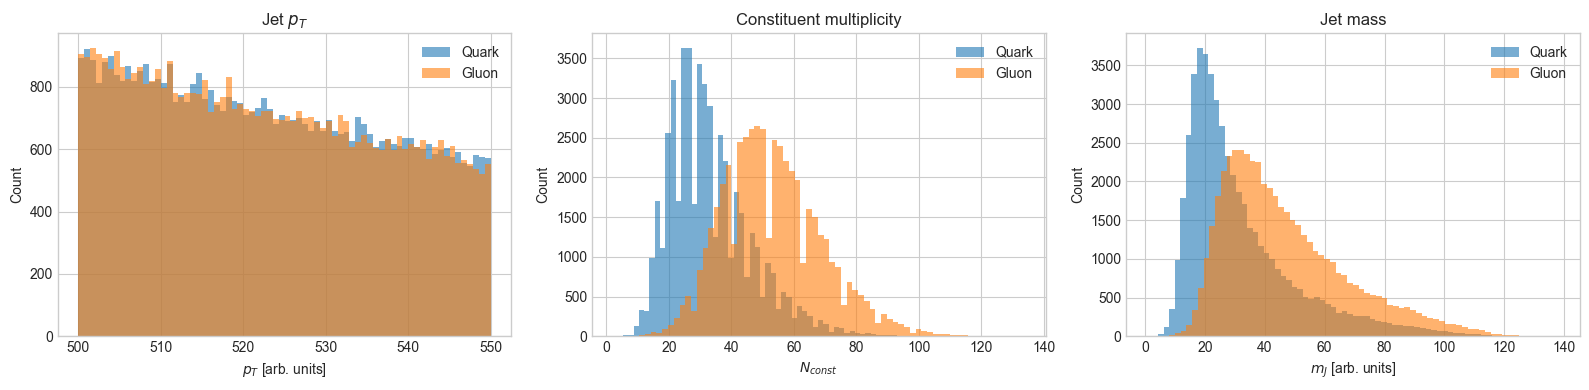

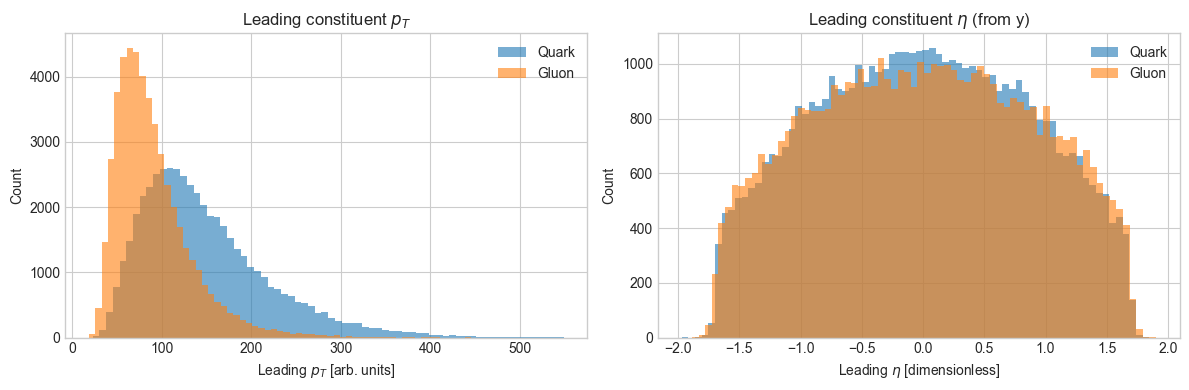

In [3]:
from jetobsmc.jet import Jet

# Build Jet objects once from masked HEPSIM constituent representation
jets_lab = [Jet.from_ptyphipdg(X_raw[i], apply_padding_mask=True) for i in range(X_raw.shape[0])]

is_quark = y_label == 1
is_gluon = y_label == 0

jet_pt = np.array([j.pt() for j in jets_lab], dtype=float)
jet_mass = np.array([j.mass() for j in jets_lab], dtype=float)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(jet_pt[is_quark], bins=70, alpha=0.6, label="Quark")
axes[0].hist(jet_pt[is_gluon], bins=70, alpha=0.6, label="Gluon")
axes[0].set_title("Jet $p_T$")
axes[0].set_xlabel("$p_T$ [arb. units]")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(multiplicity[is_quark], bins=70, alpha=0.6, label="Quark")
axes[1].hist(multiplicity[is_gluon], bins=70, alpha=0.6, label="Gluon")
axes[1].set_title("Constituent multiplicity")
axes[1].set_xlabel("$N_{const}$")
axes[1].set_ylabel("Count")
axes[1].legend()

axes[2].hist(jet_mass[is_quark], bins=70, alpha=0.6, label="Quark")
axes[2].hist(jet_mass[is_gluon], bins=70, alpha=0.6, label="Gluon")
axes[2].set_title("Jet mass")
axes[2].set_xlabel("$m_J$ [arb. units]")
axes[2].set_ylabel("Count")
axes[2].legend()

plt.tight_layout()
plt.show()

# Part (a)(iii): leading-constituent pT and eta distributions
n_jets = X_raw.shape[0]
lead_idx = np.argmax(np.where(valid, pt, -np.inf), axis=1)
has_const = multiplicity > 0

lead_pt = np.zeros(n_jets, dtype=float)
lead_eta = np.full(n_jets, np.nan, dtype=float)
rows = np.arange(n_jets)
lead_pt[has_const] = pt[rows[has_const], lead_idx[has_const]]
# Dataset provides y; use eta approximately under massless-constituent assumption
lead_eta[has_const] = y_const[rows[has_const], lead_idx[has_const]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(lead_pt[is_quark & has_const], bins=70, alpha=0.6, label="Quark")
axes[0].hist(lead_pt[is_gluon & has_const], bins=70, alpha=0.6, label="Gluon")
axes[0].set_title("Leading constituent $p_T$")
axes[0].set_xlabel("Leading $p_T$ [arb. units]")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(lead_eta[is_quark & has_const], bins=70, alpha=0.6, label="Quark")
axes[1].hist(lead_eta[is_gluon & has_const], bins=70, alpha=0.6, label="Gluon")
axes[1].set_title(r"Leading constituent $\eta$ (from y)")
axes[1].set_xlabel(r"Leading $\eta$ [dimensionless]")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Lorentz Boost to Jet Rest Frame

Closure residual mean: 2.523e-12
Closure residual max : 7.405e-11


Mass invariance |Δm| mean: 2.383e-12
Mass invariance |Δm| max : 2.866e-10
Jets with beta^2 >= guard threshold (0.999999999999999): 0


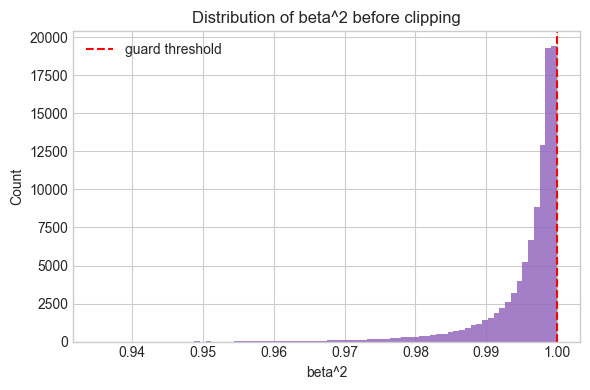

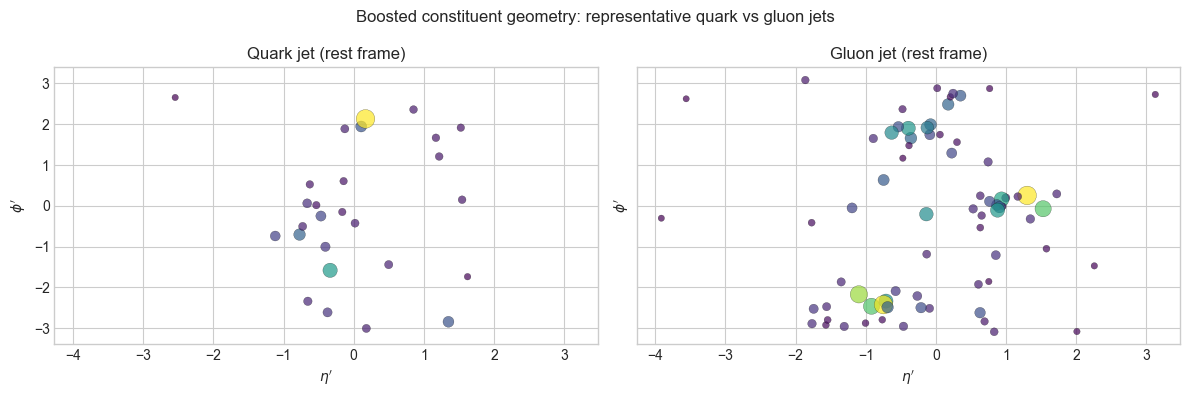

In [4]:
from jetobsmc.fourvector import jet_beta, eta_array, phi_array

# A) Closure test: ||sum p'⃗|| should be near numerical precision
residual = np.array([j.rest_frame_momentum_residual() for j in jets_lab], dtype=float)
print(f"Closure residual mean: {residual.mean():.3e}")
print(f"Closure residual max : {residual.max():.3e}")

# B) Mass invariance under Lorentz transformation
mass_after_boost = np.array([Jet(j.boosted_constituents_rest_frame()).mass() for j in jets_lab], dtype=float)
mass_diff = np.abs(jet_mass - mass_after_boost)
print(f"Mass invariance |Δm| mean: {mass_diff.mean():.3e}")
print(f"Mass invariance |Δm| max : {mass_diff.max():.3e}")

# C) Near-lightlike guard diagnostics
p4_total = np.array([j.p4.as_array() for j in jets_lab], dtype=float)
E = p4_total[:, 0]
pvec = p4_total[:, 1:4]
with np.errstate(divide='ignore', invalid='ignore'):
    beta2_raw = np.sum((pvec / E[:, None]) ** 2, axis=1)
beta2_raw = np.where(np.isfinite(beta2_raw), beta2_raw, 0.0)

# Guard threshold matches library stability clipping scale
BETA2_GUARD = 1.0 - 1e-15
n_guard = int(np.sum(beta2_raw >= BETA2_GUARD))

print(f"Jets with beta^2 >= guard threshold ({BETA2_GUARD:.15f}): {n_guard}")

plt.figure(figsize=(6, 4))
plt.hist(beta2_raw, bins=80, alpha=0.85, color='tab:purple')
plt.axvline(BETA2_GUARD, color='red', linestyle='--', label='guard threshold')
plt.title("Distribution of beta^2 before clipping")
plt.xlabel("beta^2")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Part (c)(iii): boosted-constituent scatter (quark vs gluon)
q_idx = int(np.flatnonzero(is_quark)[0])
g_idx = int(np.flatnonzero(is_gluon)[0])

q_rest = jets_lab[q_idx].boosted_constituents_rest_frame()
g_rest = jets_lab[g_idx].boosted_constituents_rest_frame()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for ax, arr, title in [
    (axes[0], q_rest, 'Quark jet (rest frame)'),
    (axes[1], g_rest, 'Gluon jet (rest frame)'),
]:
    eta_vals = eta_array(arr)
    phi_vals = phi_array(arr)
    pt_vals = np.hypot(arr[:, 1], arr[:, 2])
    size = 20.0 + 160.0 * pt_vals / (np.max(pt_vals) + 1e-12)
    ax.scatter(eta_vals, phi_vals, s=size, alpha=0.7, c=pt_vals, cmap='viridis', edgecolors='k', linewidths=0.2)
    ax.set_title(title)
    ax.set_xlabel(r"$\eta'$")
    ax.set_ylabel(r"$\phi'$")

plt.suptitle("Boosted constituent geometry: representative quark vs gluon jets")
plt.tight_layout()
plt.show()

## 5. Jet Observables

### 5.1 IRC-Safe: Multiplicity, Width, pTD

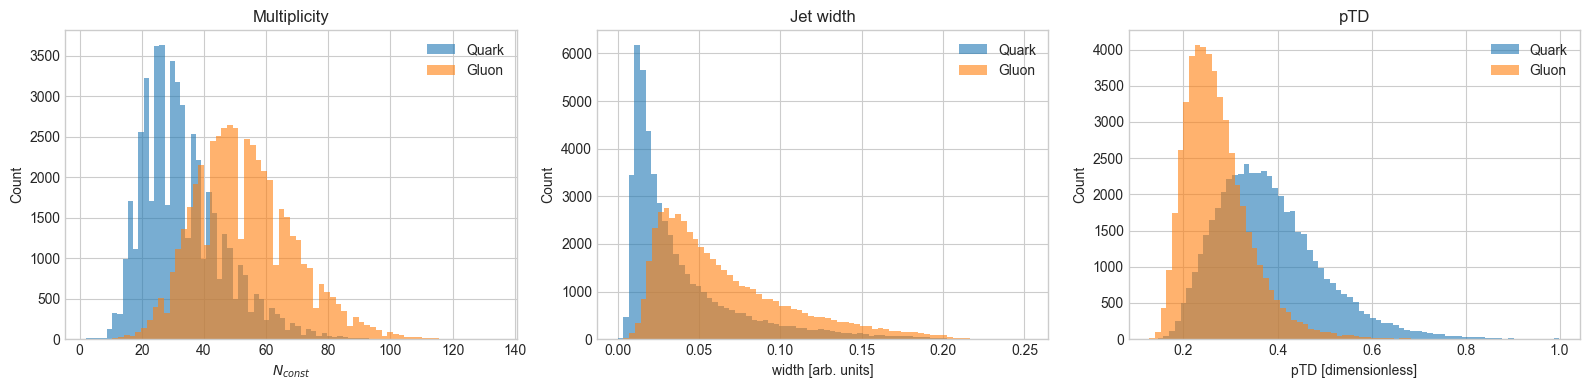

In [5]:
from jetobsmc.observables.shapes import jet_width, pt_dispersion, nsubjettiness_tau1, energy_correlation_e2
from jetobsmc.observables.kinematics import wrap_delta_phi
from jetobsmc.fourvector import eta_array, phi_array

width_lab = np.array([jet_width(j) for j in jets_lab], dtype=float)
ptd_lab = np.array([pt_dispersion(j) for j in jets_lab], dtype=float)

def _tau2_proxy(jet: Jet) -> float:
    # Two-axis proxy (top-2 pT constituent axes), intentionally lightweight for evaluation baseline.
    p = jet.particles
    if p.shape[0] < 2:
        return 0.0

    pts = np.hypot(p[:, 1], p[:, 2])
    if float(np.sum(pts)) == 0.0:
        return 0.0

    etas = eta_array(p)
    phis = phi_array(p)

    top2 = np.argsort(pts)[-2:]
    e1, p1 = etas[top2[0]], phis[top2[0]]
    e2, p2 = etas[top2[1]], phis[top2[1]]

    dr1 = np.hypot(etas - e1, wrap_delta_phi(phis - p1))
    dr2 = np.hypot(etas - e2, wrap_delta_phi(phis - p2))

    return float(np.sum(pts * np.minimum(dr1, dr2)))


tau1_lab = np.array([nsubjettiness_tau1(j) for j in jets_lab], dtype=float)
tau2_lab = np.array([_tau2_proxy(j) for j in jets_lab], dtype=float)
tau21_lab = np.divide(
    tau2_lab,
    tau1_lab,
    out=np.zeros_like(tau2_lab),
    where=tau1_lab > 0,
)
e2_lab = np.array([energy_correlation_e2(j) for j in jets_lab], dtype=float)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].hist(multiplicity[is_quark], bins=70, alpha=0.6, label='Quark')
axes[0].hist(multiplicity[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[0].set_title('Multiplicity')
axes[0].set_xlabel('$N_{const}$')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].hist(width_lab[is_quark], bins=70, alpha=0.6, label='Quark')
axes[1].hist(width_lab[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[1].set_title('Jet width')
axes[1].set_xlabel('width [arb. units]')
axes[1].set_ylabel('Count')
axes[1].legend()

axes[2].hist(ptd_lab[is_quark], bins=70, alpha=0.6, label='Quark')
axes[2].hist(ptd_lab[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[2].set_title('pTD')
axes[2].set_xlabel('pTD [dimensionless]')
axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.show()

Interpretation: gluon jets are expected to exhibit larger multiplicity and broader width due to larger color factor.

### 5.2 Substructure: tau1, tau21, e2

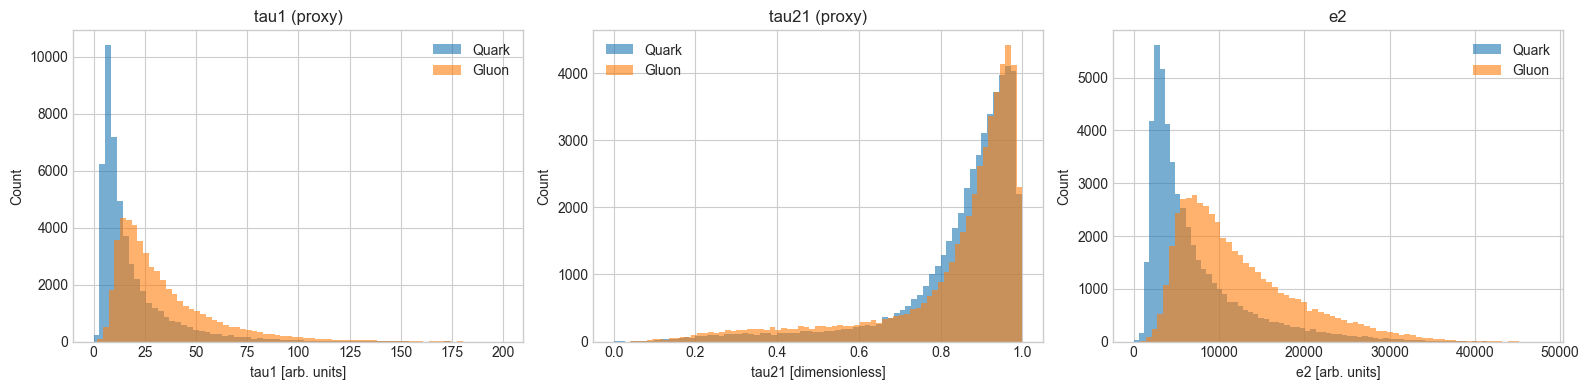

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(tau1_lab[is_quark], bins=70, alpha=0.6, label='Quark')
axes[0].hist(tau1_lab[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[0].set_title('tau1 (proxy)')
axes[0].set_xlabel('tau1 [arb. units]')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].hist(tau21_lab[is_quark], bins=70, alpha=0.6, label='Quark')
axes[1].hist(tau21_lab[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[1].set_title('tau21 (proxy)')
axes[1].set_xlabel('tau21 [dimensionless]')
axes[1].set_ylabel('Count')
axes[1].legend()

axes[2].hist(e2_lab[is_quark], bins=70, alpha=0.6, label='Quark')
axes[2].hist(e2_lab[is_gluon], bins=70, alpha=0.6, label='Gluon')
axes[2].set_title('e2')
axes[2].set_xlabel('e2 [arb. units]')
axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.show()

Interpretation: substructure proxies differentiate radiation geometry; tau21 and e2 are particularly sensitive to constituent spread.

### 5.3 Groomed (if implemented)
Groomed observables are intentionally not included in this baseline notebook to keep the evaluation pipeline minimal and auditable.

## 6. Lab vs Rest Frame Comparison

In [7]:
# Compute rest-frame features
jets_rest = [Jet(j.boosted_constituents_rest_frame()) for j in jets_lab]

width_rest = np.array([jet_width(j) for j in jets_rest], dtype=float)
ptd_rest = np.array([pt_dispersion(j) for j in jets_rest], dtype=float)
tau1_rest = np.array([nsubjettiness_tau1(j) for j in jets_rest], dtype=float)
tau2_rest = np.array([_tau2_proxy(j) for j in jets_rest], dtype=float)
tau21_rest = np.divide(tau2_rest, tau1_rest, out=np.zeros_like(tau2_rest), where=tau1_rest > 0)
e2_rest = np.array([energy_correlation_e2(j) for j in jets_rest], dtype=float)

X_lab = np.column_stack([multiplicity, width_lab, ptd_lab, tau1_lab, tau21_lab, e2_lab])
X_rest = np.column_stack([multiplicity, width_rest, ptd_rest, tau1_rest, tau21_rest, e2_rest])
feature_names = ["multiplicity", "width", "pTD", "tau1", "tau21", "e2"]

mask_finite = np.isfinite(X_lab).all(axis=1) & np.isfinite(X_rest).all(axis=1)
print(f"Finite-feature jets retained: {int(mask_finite.sum()):,} / {len(mask_finite):,}")


Finite-feature jets retained: 86,987 / 100,000


In [8]:
try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
except Exception as exc:
    raise ImportError(
        "scikit-learn is required for sections 6 and 7. Install with: pip install scikit-learn"
    ) from exc

X_lab_f = X_lab[mask_finite]
X_rest_f = X_rest[mask_finite]
y_f = y_label[mask_finite]

X_train_lab, X_test_lab, y_train, y_test = train_test_split(
    X_lab_f, y_f, test_size=0.25, random_state=SEED, stratify=y_f
)
X_train_rest, X_test_rest, _, _ = train_test_split(
    X_rest_f, y_f, test_size=0.25, random_state=SEED, stratify=y_f
)

clf_lab = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1200, random_state=SEED))
clf_rest = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1200, random_state=SEED))

clf_lab.fit(X_train_lab, y_train)
clf_rest.fit(X_train_rest, y_train)

proba_lab = clf_lab.predict_proba(X_test_lab)[:, 1]
proba_rest = clf_rest.predict_proba(X_test_rest)[:, 1]

auc_lab = roc_auc_score(y_test, proba_lab)
auc_rest = roc_auc_score(y_test, proba_rest)

print("Observable | AUC (Lab) | AUC (Rest)")
print("-----------|-----------|-----------")
print(f"All-baseline | {auc_lab:.4f}    | {auc_rest:.4f}")

Observable | AUC (Lab) | AUC (Rest)
-----------|-----------|-----------
All-baseline | 0.8539    | 0.8489


Rest-frame observables often provide modest geometric decorrelation; verify this by comparing AUC and feature coefficients below.

## 7. Quark–Gluon Discrimination Baseline

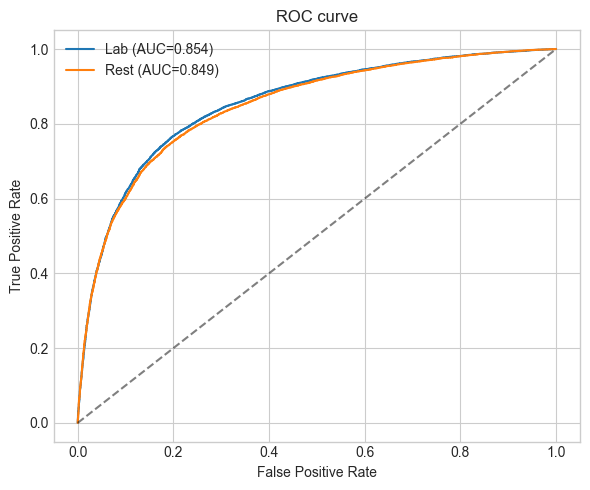

Confusion matrix (rest-frame baseline):
 [[8279 2476]
 [2413 8579]]
Top 3 discriminating features (rest-frame model):
 - multiplicity: coefficient = -1.2928
 - pTD: coefficient = +0.6291
 - e2: coefficient = +0.4535
Most discriminating single observable (rest-frame): multiplicity (coefficient = -1.2928)
Most discriminating single observable (lab): multiplicity (coefficient = -1.4991)


In [9]:
from sklearn.metrics import confusion_matrix, roc_curve

fpr_lab, tpr_lab, _ = roc_curve(y_test, proba_lab)
fpr_rest, tpr_rest, _ = roc_curve(y_test, proba_rest)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lab, tpr_lab, label=f"Lab (AUC={auc_lab:.3f})")
plt.plot(fpr_rest, tpr_rest, label=f"Rest (AUC={auc_rest:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.tight_layout()
plt.show()

pred_rest = (proba_rest >= 0.5).astype(int)
cm_rest = confusion_matrix(y_test, pred_rest)
print("Confusion matrix (rest-frame baseline):\n", cm_rest)

coef_rest = clf_rest.named_steps["logisticregression"].coef_[0]
rank = np.argsort(np.abs(coef_rest))[::-1][:3]
print("Top 3 discriminating features (rest-frame model):")
for r in rank:
    print(f" - {feature_names[r]}: coefficient = {coef_rest[r]:+.4f}")

best_idx_rest = int(np.argmax(np.abs(coef_rest)))
print(
    f"Most discriminating single observable (rest-frame): "
    f"{feature_names[best_idx_rest]} (coefficient = {coef_rest[best_idx_rest]:+.4f})"
)

coef_lab = clf_lab.named_steps["logisticregression"].coef_[0]
best_idx_lab = int(np.argmax(np.abs(coef_lab)))
print(
    f"Most discriminating single observable (lab): "
    f"{feature_names[best_idx_lab]} (coefficient = {coef_lab[best_idx_lab]:+.4f})"
)

In [10]:
q_med_width = float(np.median(width_lab[is_quark]))
g_med_width = float(np.median(width_lab[is_gluon]))
q_med_ptd = float(np.median(ptd_lab[is_quark]))
g_med_ptd = float(np.median(ptd_lab[is_gluon]))

print(f"Median width (quark): {q_med_width:.4f}")
print(f"Median width (gluon): {g_med_width:.4f}")
print(f"Median pTD (quark):  {q_med_ptd:.4f}")
print(f"Median pTD (gluon):  {g_med_ptd:.4f}")

print("Interpretation: gluon jets exhibit broader radiation patterns and lower pTD,")
print("consistent with larger color factor (CA > CF).")

Median width (quark): 0.0256
Median width (gluon): 0.0538
Median pTD (quark):  0.3674
Median pTD (gluon):  0.2600
Interpretation: gluon jets exhibit broader radiation patterns and lower pTD,
consistent with larger color factor (CA > CF).


## 8. Runtime Behavior

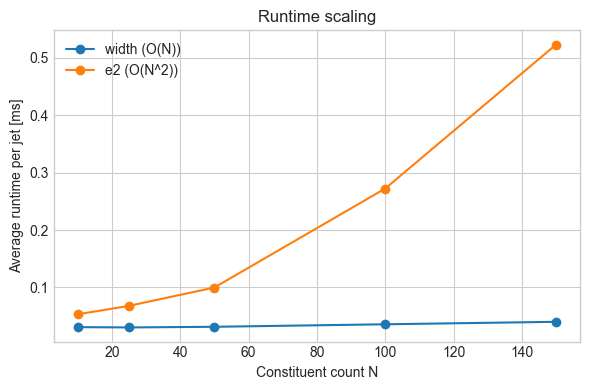

Width timings (ms): [0.031, 0.0304, 0.0316, 0.0359, 0.0402]
e2 timings (ms): [0.0533, 0.068, 0.1, 0.2723, 0.5229]


In [11]:
import time


def make_random_jet(n_const: int) -> Jet:
    pt = np.abs(rng.normal(5.0, 2.0, size=n_const)) + 1e-6
    y = rng.normal(0.0, 0.8, size=n_const)
    phi = rng.uniform(-np.pi, np.pi, size=n_const)
    pdgid = rng.choice([211, -211, 22, 130], size=n_const)
    arr = np.column_stack([pt, y, phi, pdgid])
    return Jet.from_ptyphipdg(arr, apply_padding_mask=True)

sizes = [10, 25, 50, 100, 150]
repeats = 30
width_ms, e2_ms = [], []

for n in sizes:
    jets_tmp = [make_random_jet(n) for _ in range(repeats)]

    t0 = time.perf_counter()
    for j in jets_tmp:
        _ = jet_width(j)
    width_ms.append((time.perf_counter() - t0) * 1000.0 / repeats)

    t0 = time.perf_counter()
    for j in jets_tmp:
        _ = energy_correlation_e2(j)
    e2_ms.append((time.perf_counter() - t0) * 1000.0 / repeats)

plt.figure(figsize=(6, 4))
plt.plot(sizes, width_ms, marker='o', label='width (O(N))')
plt.plot(sizes, e2_ms, marker='o', label='e2 (O(N^2))')
plt.xlabel('Constituent count N')
plt.ylabel('Average runtime per jet [ms]')
plt.title('Runtime scaling')
plt.legend()
plt.tight_layout()
plt.show()

print('Width timings (ms):', [round(v, 4) for v in width_ms])
print('e2 timings (ms):', [round(v, 4) for v in e2_ms])

## 9. Conclusions

In [12]:
print("- Canonical padding mask applied consistently: valid = (pdgid != 0) & (pT > 0)")
print(f"- Rest-frame closure residual max: {residual.max():.3e}")
print(f"- Mass invariance max |Δm|: {mass_diff.max():.3e}")
print("- Gluon jets generally show broader and higher-multiplicity structure than quark jets")
print(f"- AUC comparison: lab={auc_lab:.4f}, rest={auc_rest:.4f}")
print("- Pipeline is deterministic with fixed seed and Python 3.13-compatible structure")

- Canonical padding mask applied consistently: valid = (pdgid != 0) & (pT > 0)
- Rest-frame closure residual max: 7.405e-11
- Mass invariance max |Δm|: 2.866e-10
- Gluon jets generally show broader and higher-multiplicity structure than quark jets
- AUC comparison: lab=0.8539, rest=0.8489
- Pipeline is deterministic with fixed seed and Python 3.13-compatible structure
